# Image-Based Entity Resolution

Author: Chris Oswald

Date: October 20, 2024

Course: STA790 - Entity Resolution



## Overview of Image-Based Entity Resolution

Entity resolution, also known as record linkage, is the process of identifying noisy data points that refer to the same underlying entity (object, person, etc.). The data can be tabular (e.g., numeric or categorical variables), free-form text, or images, and typically contain an unknown number of entities, each of which is represented in an unknown number of records. Entity resolution can be used to de-duplicate a dataset or match records across multiple datasets. For a thorough overview of entity resolution, see [Binette and Steorts (2022)](https://www.science.org/doi/10.1126/sciadv.abi8021).

Image data present some unique challenges for entity resolution. First, the high dimensionality of image data substantially increases the computational cost of comparing records. Much of the information in an image may also be redundant or completely irrelevant to the entity resolution task (e.g., the image background). Domain shifts such as different camera angles, lighting, camera resolution, unconstrained poses, and occlusions can also make comparing entities across datasets difficult. Before we can compare images, we'll need to use an image encoder to project the high-dimensional images down to lower-dimensional representations that capture the key features of each image.

Image-based entity resolution has many important, real-world use cases. For example, in reverse image search, users typically have an image of an unknown entity (an object, person, etc.) and want to identify or find out more information about the entity. In business applications, e-commerce companies might want to offer visual product search to customers or ensure that they are not duplicating products on their website. Companies may also want to determine which competitors are selling products that are similar to their own. Image-based entity resolution is also critical for robotics and autonomous vehicles (AVs), where RGB camera data is one of the primary sensors used in navigation. To build maps of the world, robots need to be able to recognize landmarks and other objects they've seen before. They also need to be able to track individuals across cameras to ensure they maintain a sense of awareness of their surroundings.



## Vignette: Identifying Similar Insects from Unlabeled Images using Cosine Locality Sensitive Hashing (LSH)



 In this vignette, we'll demonstrate how to use Cosine Locality Sensitive Hashing (LSH) to identify similar images of insects from two different datasets. This method is entirely unsupervised, meaning we don't need to know the true class labels for either dataset (if we did, we could just match images based on the true labels).

### Setting Up



First, let's set up our workspace by mounting Google Drive in our Colab environment and installing/importing the necessary Python packages.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install timm -q

In [ ]:
import os
import pickle
import time
from typing import Dict, List, Optional, Type

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import timm
import torch
import torch.nn.functional as F
import torchvision.io as torch_io
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, utils

Next, we'll specify and create the paths to the data, models, and metadata directories that we'll use in this analysis.

In [ ]:
data_dir = '/content/drive/MyDrive/EntityResolution/data'
models_dir = '/content/drive/MyDrive/EntityResolution/models'
metadata_dir = '/content/drive/MyDrive/EntityResolution/metadata'

for dir in [models_dir, metadata_dir]:
    os.makedirs(dir, exist_ok=True)

Finally, we'll specify constants that we'll use throughout the vignette and set the random seed for reproducibility. The `LOAD_FROM_CHECKPOINT` variable will allow us to avoid re-encoding all images after we have encoded them the first time and have saved them to the data directory.

In [ ]:
# Define constants
RGBMODE = torch_io.image.ImageReadMode.RGB
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
RANDOM_SEED = 9999
LOAD_FROM_CHECKPOINT = False

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

### Downloading the Datasets


Let's start by loading the unlabeled datasets. We'll use two different datasets of insect images available on Kaggle:

*   [Agricultural Pests Image Dataset](https://www.kaggle.com/datasets/vencerlanz09/agricultural-pests-image-dataset?resource=download)
*   [Dangerous Farm Insects Dataset](https://www.kaggle.com/datasets/tarundalal/dangerous-insects-dataset)

Unzip the images to subfolders in the data directory and update the subfolder paths below (as needed):

In [ ]:
data1_subdir = os.path.join(data_dir, 'agricultural_pests')
data2_subdir = os.path.join(data_dir, 'dangerous_farm_insects')

We'll define a function that we can use to loop over the subfolders in each subdirectory and extract the full paths for all JPEG or PNG files.

In [ ]:
def extract_images(data_subdir: str) -> List[str]:
    """Loop over subfolders (non-recursively) and get paths for all JPEG or PNG files."""
    paths = []
    for folder in os.listdir(data_subdir):
        for file in os.listdir(os.path.join(data_subdir, folder)):
            if file.endswith((".jpg", ".jpeg", ".png")):
                paths.append(os.path.join(data_subdir, folder, file))
    return paths

data1_paths = extract_images(data1_subdir)
data2_paths = extract_images(data2_subdir)
print(f"Number of images in dataset1: {len(data1_paths)}")
print(f"Number of images in dataset2: {len(data2_paths)}")

Number of images in dataset1: 5494
Number of images in dataset2: 1526


### Loading a Pre-Trained Image Encoder

Image data is typically very high-dimensional (e.g., 128x128 pixel resolution) and contains a lot of information that is irrelevant for our particular task of matching images based on insect species. To extract the essential features of the images, we'll compress (or encode) the information by projecting the images to a lower dimensional space.

For our encoder, we'll use a Vision Transformer (ViT) [model](https://huggingface.co/timm/vit_betwixt_patch16_reg4_gap_256.sbb2_e200_in12k_ft_in1k) that has been pre-trained on [ImageNet-12k](), a subset of the original [ImageNet-22k](https://www.image-net.org/) dataset that contains about 12,000 unique classes. We'll use only the encoder part of the model to project each of our 16,384-dimensional images down to a single vector of length 512. The 512 values in this new vector can be thought of as coordinates for the image in the lower dimensional space, where each of the new dimensions captures some essential aspect of the image.

Let's start by loading the pre-trained model from HuggingFace using the [PyTorch Image Models (`timm`)](https://huggingface.co/timm) package:

In [ ]:
vit_model = timm.create_model(
    'vit_betwixt_patch16_reg4_gap_256.sbb2_e200_in12k_ft_in1k',
    pretrained=True,
    num_classes=0,  # remove classifier nn.Linear
)
vit_model = vit_model.eval().to(DEVICE)

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(vit_model)
vit_transforms = timm.data.create_transform(**data_config, is_training=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

Since the input data for the ViT model must be normalized, we'll also define an inverse normalization so we can retrieve the original images (e.g., for visualization):

In [ ]:
reverse_normalize = transforms.Normalize(
    mean=[-m/s for m, s in zip(data_config["mean"], data_config["std"])],
    std=[1/s for s in data_config["std"]]
)

### Creating an Image Dataset Class

To use PyTorch's DataLoader class for efficient input/output operations (i.e., loading the images from disk into memory), we'll create a custom Dataset class specifically for *unlabeled* image data. The `ImageDataset` class will take the list of image paths we created above, as well as a list of image transforms to perform (e.g., resizing) when loading the data.

In [ ]:
class UnlabeledImageDataset(Dataset):
    """Custom PyTorch Dataset class for unlabeled image data."""

    def __init__(
        self,
        paths_list: List[str],
        transform: Optional[transforms.Compose] = None,
        name: Optional[str] = None,
    ) -> None:
        """Initialize class with image paths and transforms."""
        super().__init__()
        self.paths = paths_list
        self.transform = transform
        self.name = name

    def __len__(self):
        """Return length of dataset."""
        return len(self.paths)

    def __getitem__(self, idx: int):
        """Returns only the imported images (labels are not available)."""
        img_path = self.paths[idx]
        img = torch_io.read_image(img_path, mode=RGBMODE).float() / 255.0 # Convert to float and normalize
        if self.transform:
            return self.transform(img)
        else:
            return img


Let's instantiate the unlabeled image datasets and visualize a few images from each. We'll use the image transforms required for the pre-trained ViT encoder model.

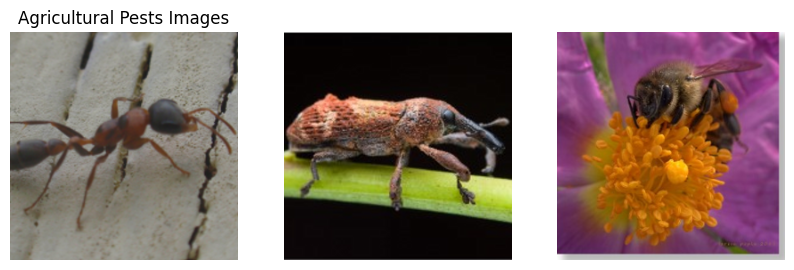

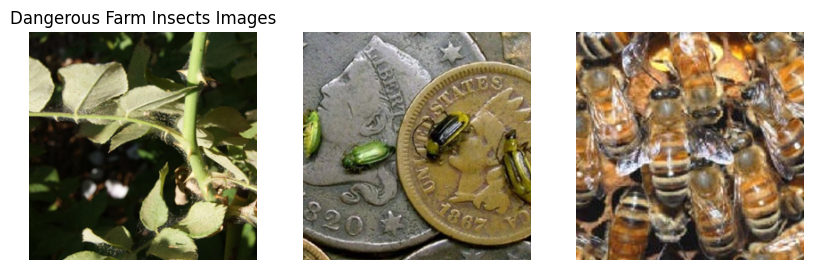

In [ ]:
# Create individual datasets
data1 = UnlabeledImageDataset(data1_paths, vit_transforms, name="agricultural_pests")
data2 = UnlabeledImageDataset(data2_paths, vit_transforms, name="dangerous_farm_insects")

# Plot n random images from each dataset
plot_n_images = 3
for dataset in [data1, data2]:
    fig, ax = plt.subplots(1, plot_n_images, figsize=(10,6))
    for j in range(plot_n_images):
        image_idx = np.random.randint(0, len(dataset))
        show_img = reverse_normalize(dataset[image_idx]).clip(0., 1.0).permute(1, 2, 0).cpu().numpy()
        ax[j].imshow(show_img)
        ax[j].axis("off")
    ax[0].set_title(f"{dataset.name.title().replace('_', ' ')} Images")

Finally, let's create a dataloader for each of the unlabeled image datasets so we can load batches of images. Note that since we're not actually training a model and we want to be able to check whether matched images appear to be from the same species, we'll set `shuffle=False`.

In [ ]:
dl1 = DataLoader(data1, batch_size=64, num_workers=4, shuffle=False, drop_last=True)
dl2 = DataLoader(data2, batch_size=64, num_workers=4, shuffle=False, drop_last=True)

### Encoding the Images

Now that we've loaded our pre-trained ViT model encoder and created our dataloaders, we can encode all of the images into lower-dimensional vectors. We'll store the vector representations for each dataset into a preallocated matrix of size `# of images, vector_length`, where `vector_length` is 640 for the specific ViT encoder we're using.

In [ ]:
def encode_all_images(encoder, transforms, dataloader):
    example_output = encoder(transforms(next(iter(dataloader)).to(DEVICE))).detach().cpu()
    batch_size = example_output.shape[0]
    vector_length = example_output.shape[-1]
    database = torch.empty((len(dataloader) * batch_size, vector_length))
    for batch_idx, batch_data in enumerate(dataloader):
        encoded_batch = encoder(transforms(batch_data.to(DEVICE))).detach().cpu()
        database[batch_idx*batch_size:(batch_idx+1)*batch_size, :] = encoded_batch
        if batch_idx % 10 == 0:
            print(
                f"Completed batch {batch_idx + 1}/{len(dataloader)} "+
                f"at time {time.strftime('%Y-%m-%d %H:%M:%S')}"
            )
    return database

In [ ]:
if LOAD_FROM_CHECKPOINT:
    encoded_data1 = torch.load(os.path.join(data_dir, 'encoded_data1.pt'), weights_only=True)
    encoded_data2 = torch.load(os.path.join(data_dir, 'encoded_data2.pt'), weights_only=True)
else:
    encoded_data1 = encode_all_images(vit_model, vit_transforms, dl1)
    encoded_data2 = encode_all_images(vit_model, vit_transforms, dl2)
    torch.save(encoded_data1, os.path.join(data_dir, 'encoded_data1.pt'))
    torch.save(encoded_data2, os.path.join(data_dir, 'encoded_data2.pt'))

### Computing Similarity Scores using Cosine Locality-Sensitive Hashing

Now that we have a lower-dimensional representation of the images in both of our datasets, we can identify image matches across datasets by quantifying the similarity of the image representations.

However, finding the **exact** best match for an image is computationally expensive, since we would need to compare each image in dataset 1 against each image in dataset 2. This operation has a complexity of $O(m*n)$, where $m$ is the number of images in dataset 1 and $n$ is the number of images in dataset 2. The complexity therefore scales linearly as $m$ **or** $n$ increases (holding the other constant), and quadratically if both increase.

A more computationally efficient approach is to use locality-sensitive hashing (LSH) to first group images based on approximate similarity, and then find the best match from the options within the same group. Specifically, we'll use Cosine LSH, since cosine similarity will allow us to quantify the similarity of vectors based on the angle between them (which is likely more informative than Euclidean distance since our "lower-dimensional" space still has a dimension of 640).

Cosine LSH works by generating random vectors that divide our lower-dimensional subspace into two regions. If the dot product of an image's representation vector with the randomly generated vector is positive, then the vectors are similar in direction; if negative, then the vectors point in opposite directions. The vectors are parallel if the dot product is exactly zero.

For each randomly generated vector, if that vector and image representation vector point in the same direction (i.e., the dot product is greater than 0), we will assign to that image's hash a bit value of 1; if negative, we will assign a bit value of 0. The total length of the hash for each image depends on how many randomly generated vectors we decide to use. For example, if we generate 10 random vectors, an image might have a hash that looks like `[0, 1, 1, 0, 1, 0, 0, 1, 0, 0]`. Using more vectors results in an image hash that is more unique, thereby reducing the size of the bin that the image will be grouped into, which increases accuracy at the cost of computational complexity.

Since we're compute the cosine similarity between vectors, we'll need to normalize our vectors so that they have unit length; then the cosine similarity will just be the dot product between the vectors. To create unit vectors, for each vector, we'll divide each component of that vector by the vector's L2 norm.

In [ ]:
encoded_data1_norm = encoded_data1.norm(p=2, dim=1, keepdim=True)
unit_encoded_data1 = encoded_data1 / encoded_data1_norm

encoded_data2_norm = encoded_data2.norm(p=2, dim=1, keepdim=True)
unit_encoded_data2 = encoded_data2 / encoded_data2_norm

We'll then specify the hash length (i.e., the number of random vectors we want to generate) and generate random unit vectors.

In [ ]:
hash_length = 20
rand_vecs = torch.randn(size=(hash_length, encoded_data1.shape[1]), requires_grad=False)
rand_vecs_norm = rand_vecs.norm(p=2, dim=1, keepdim=True)
unit_rand_vecs = rand_vecs / rand_vecs_norm

Now we'll take the dot product of our image unit representation vectors and randomly generated unit vectors to create the hash for each image. We can do this in one matrix multiplication operation by transposing our random unit vector matrix. We'll then assign the value `1` to each component that is greater than (or equal to) zero, and `0` otherwise.

In [ ]:
dot_product_matrix1 = torch.matmul(unit_encoded_data1, unit_rand_vecs.T)
hash_matrix1 = torch.where(dot_product_matrix1 >= 0, 1, 0)

dot_product_matrix2 = torch.matmul(unit_encoded_data2, unit_rand_vecs.T)
hash_matrix2 = torch.where(dot_product_matrix2 >= 0, 1, 0)

We can verify that we have a hash for each image for both datasets:

In [ ]:
print(f"Hash matrix shapes: dataset1 = {list(hash_matrix1.shape)}, dataset2 = {list(hash_matrix2.shape)}")

Hash matrix shapes: dataset1 = [5440, 20], dataset2 = [1472, 20]


In [ ]:
hash_matrix1

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 1,  ..., 0, 0, 1],
        [0, 0, 0,  ..., 1, 0, 1],
        ...,
        [0, 1, 1,  ..., 0, 0, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

In [ ]:
hash_matrix2

tensor([[1, 1, 1,  ..., 0, 0, 1],
        [0, 1, 1,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        ...,
        [0, 1, 1,  ..., 0, 1, 0],
        [1, 0, 1,  ..., 0, 0, 1],
        [0, 0, 1,  ..., 0, 1, 0]])

For each image in dataset 1, we can now use its hash to find similar images in dataset 2. We'll look for hashes that match exactly, but this is a design choice we're making since we have low-dimensional hashes (i.e., length of 20). For higher-dimensional hashes, we may want to match hashes using an approximate matching technique.

We can check for exact matches through another matrix multiplication. If the hash of image $i$ from dataset 1 exactly matches the hash of image $j$ from dataset 2, then the $a_{ij}$ value of the resulting matrix will equal the sum of the hash of image $i$ (or $j$).


In [ ]:
hash_product_matrix = torch.matmul(hash_matrix1, hash_matrix2.T)
print(hash_product_matrix)

tensor([[6, 4, 5,  ..., 5, 2, 2],
        [7, 3, 4,  ..., 6, 5, 4],
        [5, 2, 5,  ..., 5, 3, 4],
        ...,
        [7, 5, 5,  ..., 4, 6, 5],
        [9, 7, 6,  ..., 5, 6, 5],
        [8, 6, 6,  ..., 6, 4, 4]])


In [ ]:
grouping_matrix = torch.where(
    hash_product_matrix == torch.sum(hash_matrix1, dim=1).unsqueeze(1), 1, 0
)

The grouping matrix is an $m$ x $n$ matrix, where $m$ is the number of images in dataset 1, $n$ is the number of images in dataset 2, and $a_{i,j}$ equals 1 if the $i^{th}$ image from dataset 1 and the $j^{th}$ image from dataset 2 are binned together, and 0 if they are not.

In [ ]:
print(f"Grouping matrix shape: {list(grouping_matrix.shape)}")

Grouping matrix shape: [5440, 1472]


In [ ]:
print(grouping_matrix)

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])


Let's visualize the number of images from dataset 2 that were matched to each image from dataset 1, and vice versa.

Dataset 1
Number of unmatched images: 1950
Number of matched images: 3490
Median number of matched images: 2.0
--------------------------------------------------
Dataset 2
Number of unmatched images: 155
Number of matched images: 1317
Median number of matched images: 10.0
--------------------------------------------------


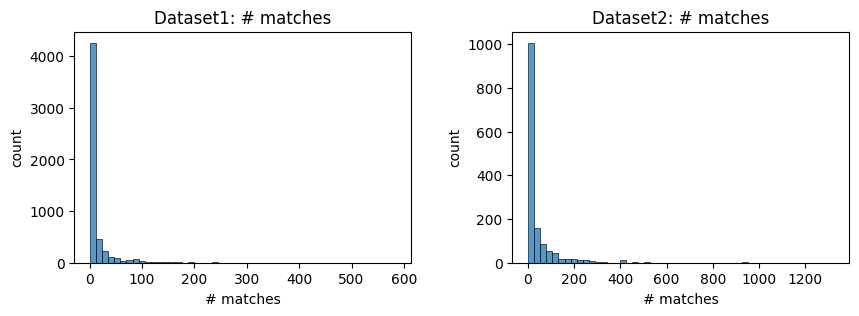

In [ ]:
match_image_count_data1 = torch.sum(grouping_matrix, dim=1).numpy()
match_image_count_data2 = torch.sum(grouping_matrix, dim=0).numpy()

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
fig.subplots_adjust(wspace=0.3)
sns.histplot(match_image_count_data1, ax=axes[0], bins=50)
sns.histplot(match_image_count_data2, ax=axes[1], bins=50)
axes[0].set_title("Dataset1: # matches")
axes[1].set_title("Dataset2: # matches")
for i in range(2):
    axes[i].set_xlabel("# matches")
    axes[i].set_ylabel("count")

print(f"Dataset 1\nNumber of unmatched images: {np.sum(match_image_count_data1 == 0)}")
print(f"Number of matched images: {np.sum(match_image_count_data1 > 0)}")
print(f"Median number of matched images: {np.median(match_image_count_data1)}")
print("-"*50)
print(f"Dataset 2\nNumber of unmatched images: {np.sum(match_image_count_data2 == 0)}")
print(f"Number of matched images: {np.sum(match_image_count_data2 > 0)}")
print(f"Median number of matched images: {np.median(match_image_count_data2)}")
print("-"*50)

Finally, let's calculate the cosine similarity between the image representation vectors (not the hashes) for images that are in the same group. To do this, for each image in dataset 1, we'll extract the indices of the dataset 2 images that are in the same group as the dataset 1 image, based on our grouping matrix. We'll store these dataset 2 indices as a list in a dictionary, where the keys of the dictionary correspond to the particular images from dataset 1. (We could create a similar dictionary for dataset 2, but for now, we'll demonstrate the process only on dataset 1.)

In [ ]:
data1_idxs_dict = {row: [] for row in range(grouping_matrix.shape[0])}
data1_nonzero_idxs = torch.nonzero(grouping_matrix)
for i in range(len(data1_nonzero_idxs)):
    data1_idx = data1_nonzero_idxs[i, 0].item()
    data2_idx = data1_nonzero_idxs[i, 1].item()
    data1_idxs_dict[data1_idx].append(data2_idx)

Now for any image in dataset 1, we can identify the images from dataset 2 that we grouped with the image from dataset 1 based on the Cosine Locality Sensitive Hashing procedure, and calculate the actual cosine similarity of the image representations. We'll randomly choose 5 images from dataset 1 to evaluate.

First, we'll create functions to visualize each image from dataset 1 with its closest matches from dataset 2, as well as the cosine similarities.

In [ ]:
def plot_closest_match(data1_idx, max_data2_idxs, data1, data2):
    n_cols = 1 + len(max_data2_idxs)
    fig, ax = plt.subplots(1, n_cols, figsize=(12,6))
    plot_img1 = reverse_normalize(data1[data1_idx]).clip(0., 1.0).permute(1, 2, 0).cpu().numpy()
    ax[0].imshow(plot_img1)
    # 1st, 2nd, and 3rd highest matches (if available)
    for i in range(len(max_data2_idxs)):
        plot_img2 = reverse_normalize(data2[max_data2_idxs[i]]).clip(0., 1.0).permute(1, 2, 0).cpu().numpy()
        ax[i+1].imshow(plot_img2)
        ax[i+1].set_title(f"Closest Match #{i+1}")
    for i in range(n_cols):
        ax[i].axis("off")
    ax[0].set_title(f"{data1.name.title().replace('_', ' ')} Image")
    plt.tight_layout(pad=3.0)
    plt.show()

def plot_cosine_similarities(cosine_sims):
    fig, ax = plt.subplots(1, 1, figsize=(8,4))
    sns.barplot(x=list(range(len(cosine_sims))), y=cosine_sims, ax=ax)
    ax.set_title("Cosine Similarity Scores")
    ax.set_xlabel("Dataset2 Image Index")
    ax.set_ylabel("Cosine Similarity")
    show_every_n_idxs = max(1, int(len(cosine_sims)/10))
    ax.set_xticks(ax.get_xticks()[::show_every_n_idxs])
    plt.tight_layout(pad=3.0)
    plt.show()

Then we'll randomly select some images from dataset 1, get the images in dataset 2 that were grouped with the image from dataset 1, and compute the cosine similarity scores between representation vectors to determine the top matches.

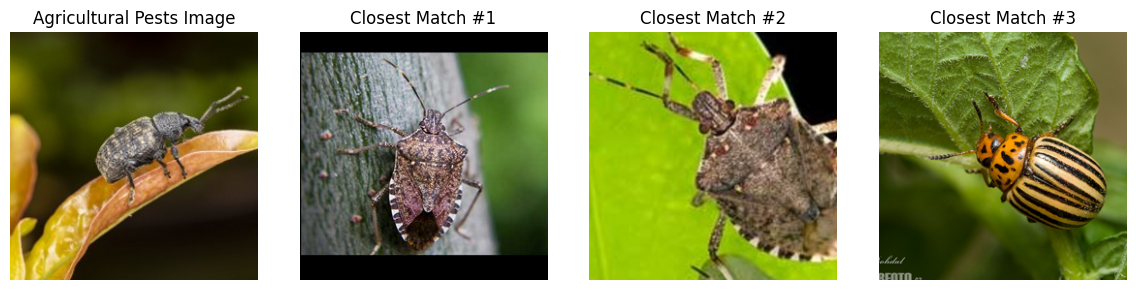

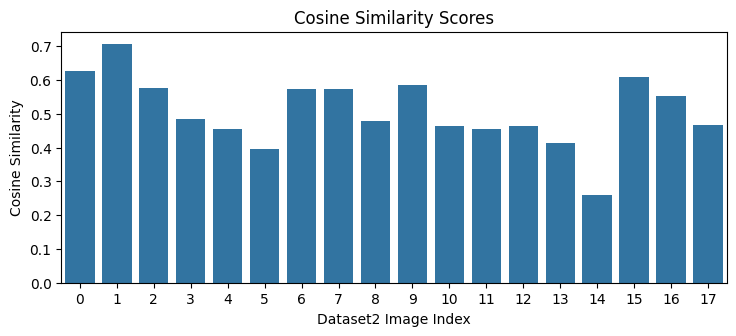

------------------------------------------------------------------------------------------------------------------------------------------------------



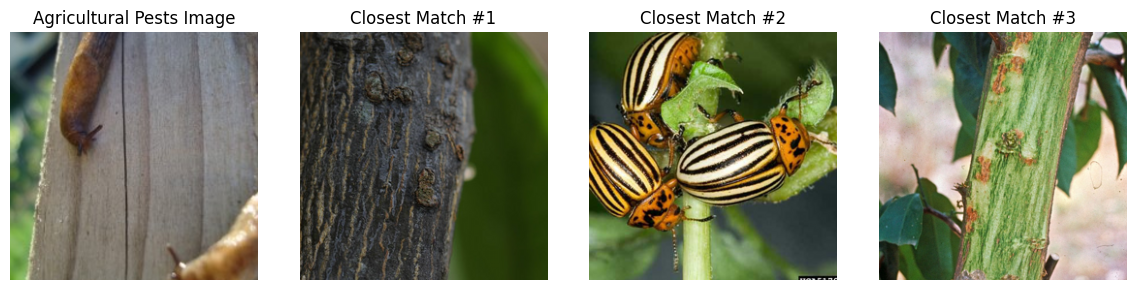

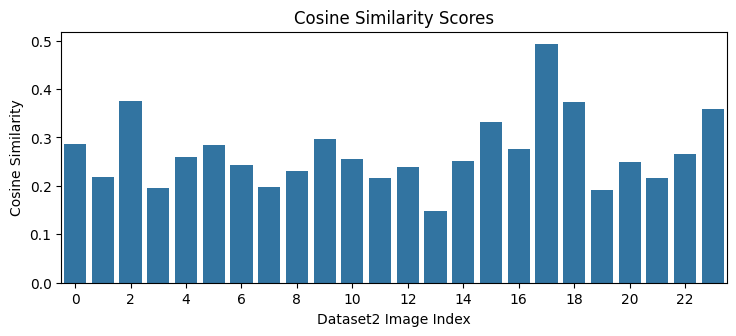

------------------------------------------------------------------------------------------------------------------------------------------------------



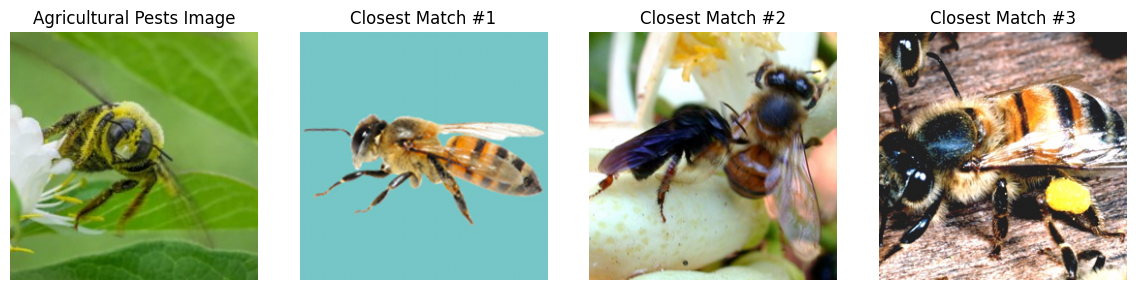

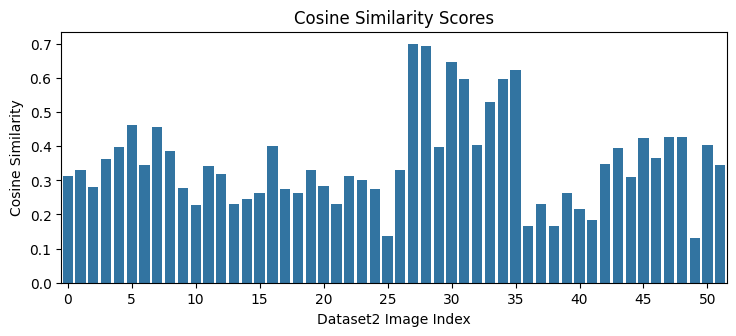

------------------------------------------------------------------------------------------------------------------------------------------------------



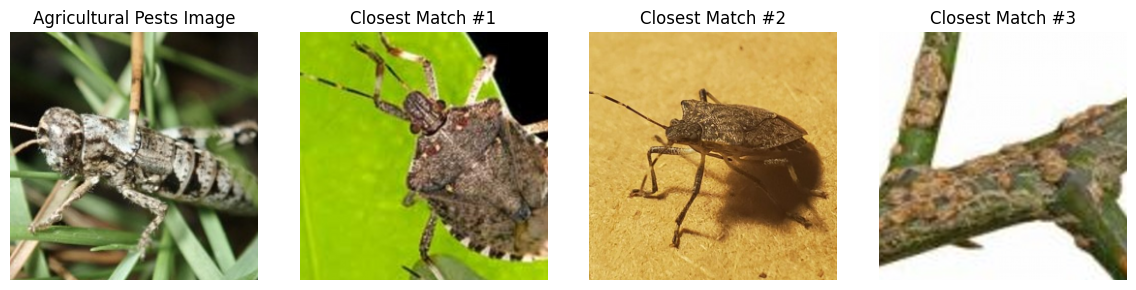

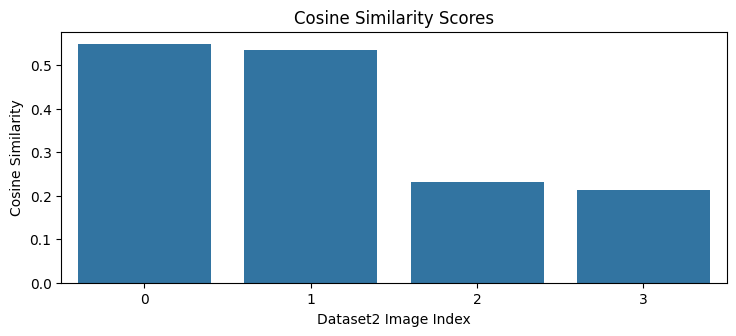

------------------------------------------------------------------------------------------------------------------------------------------------------



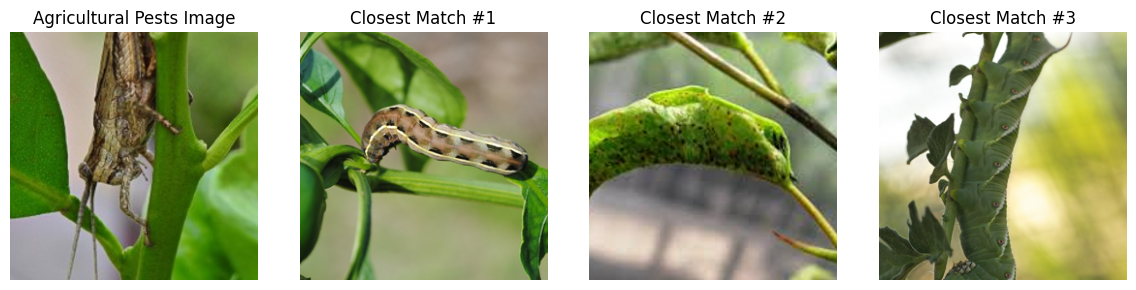

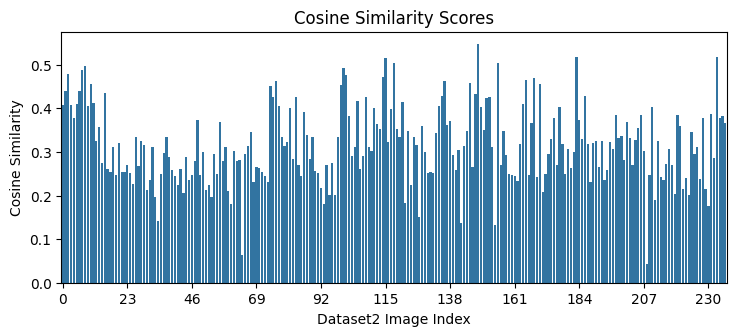

------------------------------------------------------------------------------------------------------------------------------------------------------



In [ ]:
evaluate_n_images = 5
plot_n_matches = 3
counter = 0
while counter < evaluate_n_images:
    data1_idx = np.random.choice(list(data1_idxs_dict.keys()), size=1)[0]
    # Extract representation for image from dataset 1
    data1_img_repr = unit_encoded_data1[data1_idx]
    # Extract indices of grouped images from dataset 2
    data2_idxs = data1_idxs_dict[data1_idx]
    # Get index of dataset 2 image that has closest cosine similarity to dataset 1 image
    if not data2_idxs:
        continue
    else:
        # Compute cosine similarities
        cosine_sims = []
        for data2_idx in data2_idxs:
            data2_img_repr = unit_encoded_data2[data2_idx]
            cosine_sims.append(torch.dot(data1_img_repr, data2_img_repr).item())
        # Get index of dataset 2 image with highest probability match to dataset 1 image
        top_n_idxs = np.argsort(cosine_sims)[::-1][:plot_n_matches] # Top n in descending order
        max_data2_idxs_sorted = [data2_idxs[x] for x in top_n_idxs]
    # Plot images
    if len(max_data2_idxs_sorted) == plot_n_matches:
        plot_closest_match(data1_idx, max_data2_idxs_sorted, data1, data2)
        plot_cosine_similarities(cosine_sims)
        counter += 1
        print(f"{'-'*150}\n")

We can see from the cosine similarity plots that the number of images from dataset 2 that were binned into the same group varies widely, but in all cases the number of similarity scores we need to compute is much less than computing scores for all possible images from dataset 2. Additionally, assuming we don't have the ground truth labels for images for both datasets (otherwise we could just match images based on labels), we can evaluate the results qualitatively to determine if an insect in dataset 1 actually has a match in dataset 2. In some cases, this may require domain expertise to determine if insects in two different images are truly a match, but at the very least, we've significantly reduced the number of potential matches that a human would need to evaluate manually.

Finally, it's worth noting that we used an off-the-shelf image encoder trained on the ImageNet dataset, which contains a wide range of image classes--most of which are not at all related to our particular use case of identifying common insect species. It may be possible to significantly improve the quality of matches by first training a specialized image encoder on insect-specific data, and then using that encoder to create the image representation vectors that we use for the Cosine Locality-Sensitive Hashing method.

### Sources and Additional Reading

1. Binette, Olivier and Rebecca C. Steorts. (2022) *(Almost) all of entity resolution*. Science Advances, Vol 8, Issue 12. https://www.science.org/doi/10.1126/sciadv.abi8021.
2. Deng et al. (2009) *ImageNet: A large-scale hierarchical image database*. CVPR. https://ieeexplore.ieee.org/document/5206848.
3. Dosovitskiy et al. (2021) *An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale*. ICLR. https://arxiv.org/pdf/2010.11929.
4. Fu et al. (2021) *Unsupervised Pre-Training for Person Re-identification*. https://arxiv.org/pdf/2012.03753v2.
5. Hansen et al. (2019) *Species-level image classification with convolutional neural network enables insect identification from habitus images*. https://onlinelibrary.wiley.com/doi/10.1002/ece3.5921.
6. Jain, Tarun and Rahul Jayyn. (2023). *Dangerous Farm Insects Dataset*. [Data]. https://www.kaggle.com/datasets/tarundalal/dangerous-insects-dataset/data.
7. Li et al. (2014) *DeepReID: Deep Filter Pairing Neural Network for Person Re-Identification*. https://openaccess.thecvf.com/content_cvpr_2014/papers/Li_DeepReID_Deep_Filter_2014_CVPR_paper.pdf.
8. Vencer, Lanz. (2022) *Agricultural Pests Image Dataset*. [Data]. https://www.kaggle.com/datasets/vencerlanz09/agricultural-pests-image-dataset/data.
9. Wieczorek et al. (2021) *On the Unreasonable Effectiveness of Centroids in Image Retrieval*. https://arxiv.org/pdf/2104.13643v1.
10. Ye et al. (2021) *Deep Learning for Person Re-identification: A Survey and Outlook*. https://arxiv.org/pdf/2001.04193.
11. Zhou et al. (2019) *Omni-Scale Feature Learning for Person Re-Identification*. https://arxiv.org/abs/1905.00953.














